In [1]:
# Generic python packages
import numpy as np
import pylab as plt

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.geom as geom
import lsst.afw.coord as afwCoord

import lsst.afw.geom as afwGeom
import gc
afwDisplay.setDefaultBackend('matplotlib')

In [2]:
def remove_figure(fig):
    """Remove a figure to reduce memory footprint. """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()      # clear the figure
    plt.close(fig) # close the figure
    gc.collect()   # call the garbage collector

In [3]:
# This should match the verified version listed at the start of the notebook
! eups list -s lsst_distrib

   22.0.1-3-g7ae64ea+517d8e5442 	current w_2021_49 setup


In [4]:
repo = 's3://butler-us-central1-dp01'

In [5]:
collection = "2.2i/runs/DP0.1"

In [6]:
butler = dafButler.Butler(repo, collections=collection)
registry = butler.registry

In [7]:
datasetRefs = registry.queryDatasets(datasetType='deepCoadd', collections=collection)

for i, ref in enumerate(datasetRefs):
    #print(ref.dataId.full)
    print(ref.dataId)
    #print(ref.dataId['band'])
    print(' ')
    if i > 2:
        break

{band: 'u', skymap: 'DC2', tract: 4029, patch: 25}
 
{band: 'u', skymap: 'DC2', tract: 4029, patch: 46}
 
{band: 'u', skymap: 'DC2', tract: 4029, patch: 14}
 
{band: 'u', skymap: 'DC2', tract: 4029, patch: 10}
 


In [8]:
data_id={'band': 'u', 'skymap': 'DC2', 'tract': 4029, 'patch': 25}
patch = butler.get('deepCoadd',dataId=data_id)

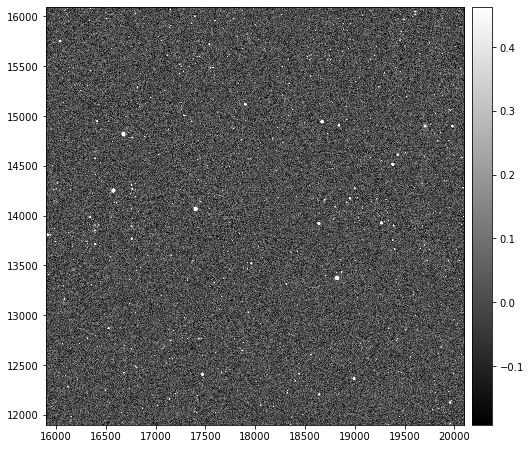

In [9]:
display = afwDisplay.Display(backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(patch.getMaskedImage().getImage())

In [10]:
src = butler.get('deepCoadd_forced_src', data_id)

# Define src as a copy in order to manipulate it.
src = src.copy(True)

In [11]:
src_point=src[src["base_ClassificationExtendedness_value"]==0]

fig = plt.figure()
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(patch.getMaskedImage().getImage())
plt.gca().axis('off')

# Use display buffering to avoid re-drawing the image after each source is plotted
with afw_display.Buffering():
    for s in src_point[:100]:
        #afw_display.dot('+', s.getX(), s.getY(), ctype=afwDisplay.RED)
        afw_display.dot('o', s.getX(), s.getY(), size=20, ctype='orange')

In [12]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given afw SpherePoint radec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Client providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, degrees
    dec: float
        Declination of the center of the cutout, degrees
    filter: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Side of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """

    radec = geom.SpherePoint(ra, dec)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize//2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox':bbox}

    cutout_image = butler.get(datasetType, parameters=parameters, dataId=coaddId)

    return cutout_image

The size of the cutout is:  (200, 200)


(19389.5, 19589.5, 11832.5, 12032.5)

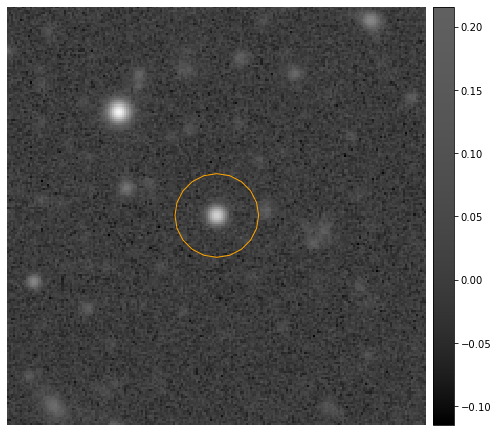

In [13]:
i=0
ra, dec = src_point[i]["coord_ra"], src_point[i]["coord_dec"]
x,y=src_point[i].getX(),src_point[i].getY()

cutout_image = cutout_coadd(butler, ra, dec, datasetType='deepCoadd', 
                            cutoutSideLength=200)
print("The size of the cutout is: ", cutout_image.image.array.shape)

# Display the image cutout
fig = plt.figure()
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(cutout_image.image)
with afw_display.Buffering():
    afw_display.dot('o', src_point[i].getX(), src_point[i].getY(), size=20, ctype='orange')
plt.gca().axis('off')



In [14]:
ccdInputs = cutout_image.getInfo().getCoaddInputs().ccds

In [21]:
visitInputs.getSchema()

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['I'](name="bbox_min_x", doc="bounding box (minimum)", units="pixel"), Key<I>(offset=8, nElements=1)),
    (Field['I'](name="bbox_min_y", doc="bounding box (minimum)", units="pixel"), Key<I>(offset=12, nElements=1)),
    (Field['I'](name="bbox_max_x", doc="bounding box (maximum)", units="pixel"), Key<I>(offset=16, nElements=1)),
    (Field['I'](name="bbox_max_y", doc="bounding box (maximum)", units="pixel"), Key<I>(offset=20, nElements=1)),
    (Field['I'](name="goodpix", doc="Number of good pixels in the coaddTempExp"), Key<I>(offset=24, nElements=1)),
    (Field['D'](name="weight", doc="Weight for this visit in the coadd"), Key<D>(offset=32, nElements=1)),
    (Field['String'](name="filter", doc="Filter associated with this visit.", size=32), Key<String>(offset=40, nElements=32)),
)

In [20]:
ccdInputs.getSchema()

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['I'](name="bbox_min_x", doc="bounding box (minimum)", units="pixel"), Key<I>(offset=8, nElements=1)),
    (Field['I'](name="bbox_min_y", doc="bounding box (minimum)", units="pixel"), Key<I>(offset=12, nElements=1)),
    (Field['I'](name="bbox_max_x", doc="bounding box (maximum)", units="pixel"), Key<I>(offset=16, nElements=1)),
    (Field['I'](name="bbox_max_y", doc="bounding box (maximum)", units="pixel"), Key<I>(offset=20, nElements=1)),
    (Field['I'](name="ccd", doc="cameraGeom CCD serial number"), Key<I>(offset=24, nElements=1)),
    (Field['L'](name="visit", doc="Foreign key for the visits (coaddTempExp) catalog"), Key<L>(offset=32, nElements=1)),
    (Field['I'](name="goodpix", doc="Number of good pixels in this CCD"), Key<I>(offset=40, nElements=1)),
    (Field['D'](name="weight", doc="Weight for this visit in the coadd"), Key<D>(offset=48, nElements=1)),
    (Field['String'](name="

In [16]:
visitInputs = patch.getInfo().getCoaddInputs().visits

In [17]:
ccdDict = dict((int(v), int(ccd)) for v, ccd in zip(ccdInputs.get("visit"), ccdInputs.get("ccd")))


In [18]:
ccdInputs.get("visit")[0]

193080

In [19]:
Registry.expandDataId()

NameError: name 'Registry' is not defined

In [ ]:
radec = geom.SpherePoint(ra, dec)

In [ ]:
radec

In [150]:
xy
afw_display.dot('o', xy[0],xy[1], size=20, ctype='orange')
plt.show()


In [154]:
visits=[]
for i in range(0,20):
    v=ccdInputs.get("visit")[i]
    band=str('u')
    dataId = {'visit': v, 'detector': ccdDict[v], 'band':'u'}
    calexp = butler.get('calexp',**dataId)
    
    boxd = geom.Box2D(calexp.getBBox())
    istrue=boxd.contains(calexp.getWcs().skyToPixel(radec))
    #print(istrue)
    if istrue:
        visits.append(v)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/obs_base/22.0.1-29-ge050cc6+6e21b5568a/python/lsst/obs/base/formatters/fitsExposure.py:623: UserWarning: Data ID {instrument: 'LSSTCam-imSim', detector: 6, visit: 193110} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for {missing}; "
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/obs_base/22.0.1-29-ge050cc6+6e21b5568a/python/lsst/obs/base/formatters/fitsExposure.py:623: UserWarning: Data ID {instrument: 'LSSTCam-imSim', detector: 161, visit: 193183} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing 

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/obs_base/22.0.1-29-ge050cc6+6e21b5568a/python/lsst/obs/base/formatters/fitsExposure.py:623: UserWarning: Data ID {instrument: 'LSSTCam-imSim', detector: 10, visit: 193080} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for {missing}; "


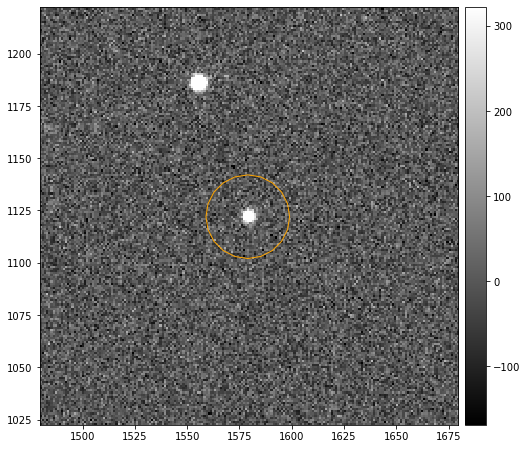

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/obs_base/22.0.1-29-ge050cc6+6e21b5568a/python/lsst/obs/base/formatters/fitsExposure.py:623: UserWarning: Data ID {instrument: 'LSSTCam-imSim', detector: 10, visit: 193080} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for {missing}; "


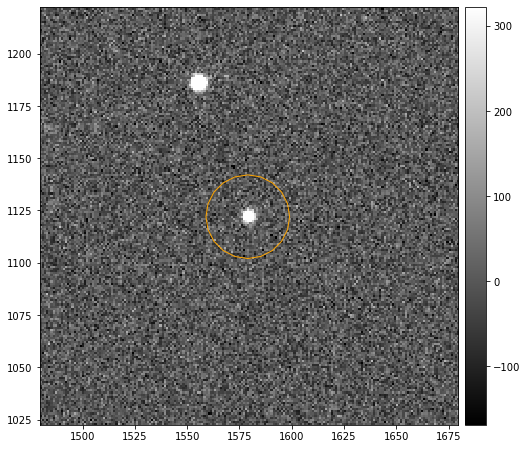

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/obs_base/22.0.1-29-ge050cc6+6e21b5568a/python/lsst/obs/base/formatters/fitsExposure.py:623: UserWarning: Data ID {instrument: 'LSSTCam-imSim', detector: 6, visit: 193110} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for {missing}; "


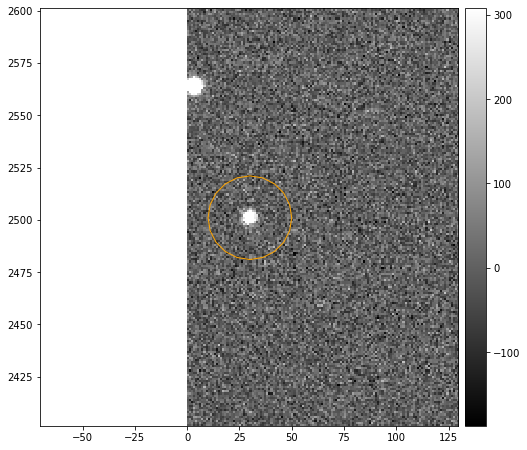

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/obs_base/22.0.1-29-ge050cc6+6e21b5568a/python/lsst/obs/base/formatters/fitsExposure.py:623: UserWarning: Data ID {instrument: 'LSSTCam-imSim', detector: 40, visit: 193882} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for {missing}; "


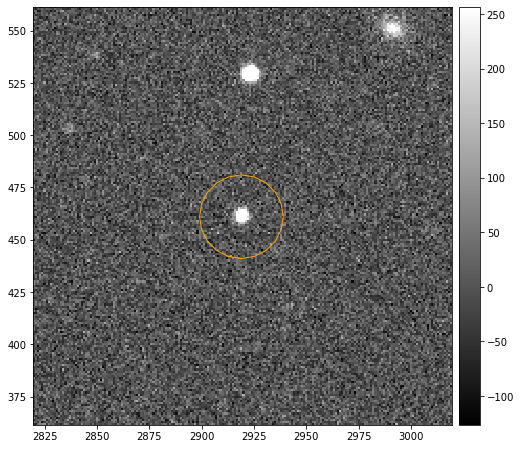

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/obs_base/22.0.1-29-ge050cc6+6e21b5568a/python/lsst/obs/base/formatters/fitsExposure.py:623: UserWarning: Data ID {instrument: 'LSSTCam-imSim', detector: 40, visit: 193882} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for {missing}; "


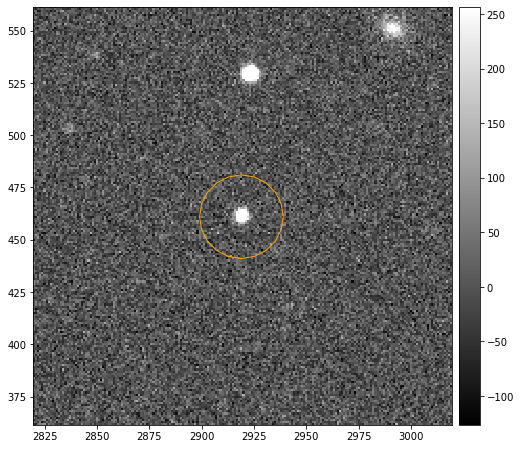

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/obs_base/22.0.1-29-ge050cc6+6e21b5568a/python/lsst/obs/base/formatters/fitsExposure.py:623: UserWarning: Data ID {instrument: 'LSSTCam-imSim', detector: 40, visit: 193882} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for {missing}; "


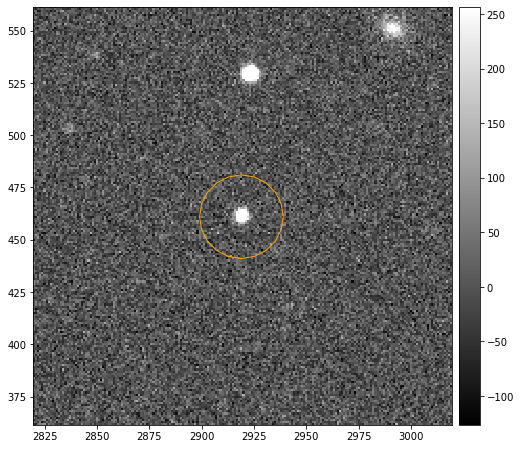

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/obs_base/22.0.1-29-ge050cc6+6e21b5568a/python/lsst/obs/base/formatters/fitsExposure.py:623: UserWarning: Data ID {instrument: 'LSSTCam-imSim', detector: 40, visit: 193882} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for {missing}; "


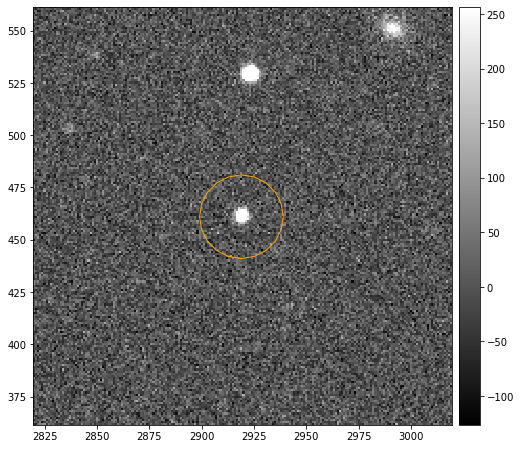

In [159]:
for v in visits:
    dataId = {'visit': v, 'detector': ccdDict[v], 'band':'u'}
    calexp = butler.get('calexp',**dataId)
    calexp=calexp.getCutout(radec, size=geom.Extent2I(200, 200))
    fig = plt.figure()
    display = afwDisplay.Display(1)
    display.scale("linear", "zscale")
    display.mtv(calexp.image)
    xy = geom.PointI(calexp.getWcs().skyToPixel(radec))
    display.dot('o', xy[0],xy[1], size=20, ctype='orange')
    plt.show()
    # clean up memory
    remove_figure(fig)


In [70]:
calexp=calexp.getCutout(radec, size=geom.Extent2I(500, 500))
display = afwDisplay.Display(backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(calexp.image)
xy = geom.PointI(calexp.getWcs().skyToPixel(radec))
display.dot('o', xy[0],xy[1], size=20, ctype='orange')
plt.show()
# clean up memory
remove_figure(fig)

False

In [48]:
radec

SpherePoint(62.3138534942011*geom.degrees, -35.072908274636845*geom.degrees)

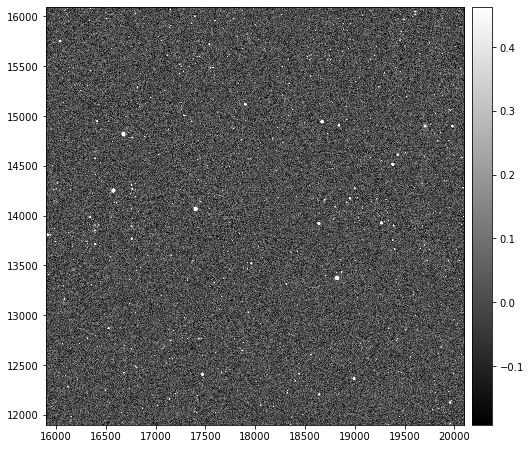

In [60]:
display = afwDisplay.Display(backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(patch.getMaskedImage().getImage())

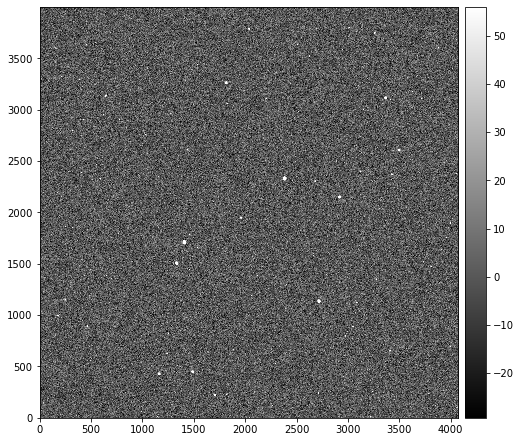

In [ ]:
display = afwDisplay.Display(backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(calexp.getMaskedImage().getImage())